# U-Net Segmentation with PyTorch Lightning
### Lab: Implementing U-Net for Image Segmentation

**Goal**: Learn to use PyTorch Lightning to train a U-Net for image segmentation.

In this lab, we will build and train a U-Net model using PyTorch Lightning on a dataset for image segmentation.

**Dataset**: We will use the ISBI Cell Segmentation dataset.

---

## 1. Installing Dependencies
You will need the following libraries:
- `pytorch-lightning`
- `torch`
- `torchvision`
- `opencv-python` (for image handling)
- `albumentations` (for data augmentation)

Install them using the following command:

In [210]:
!pip install pytorch-lightning torch torchvision opencv-python albumentations
!pip install torchmetrics

## 2. Dataset Preparation
We will use the ISBI Cell Segmentation dataset. The following code defines a custom dataset class for loading images and their corresponding masks.

Make sure to replace `path_to_train_images` and `path_to_train_masks` with the actual dataset paths.

In [211]:
!wget https://downloads.imagej.net/ISBI-2012-challenge.zip

--2024-11-22 13:31:54--  https://downloads.imagej.net/ISBI-2012-challenge.zip
Resolving downloads.imagej.net (downloads.imagej.net)... 144.92.48.183
Connecting to downloads.imagej.net (downloads.imagej.net)|144.92.48.183|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31487579 (30M) [application/zip]
Saving to: ‘ISBI-2012-challenge.zip.35’

ISBI-2012-challenge 100%[===================>]  30.03M  31.1MB/s    in 1.0s    

2024-11-22 13:31:55 (31.1 MB/s) - ‘ISBI-2012-challenge.zip.35’ saved [31487579/31487579]



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Nombre d'images dans le dataset : 24
Batch image shape: torch.Size([4, 1, 128, 128])
Batch mask shape: torch.Size([4, 1, 128, 128])


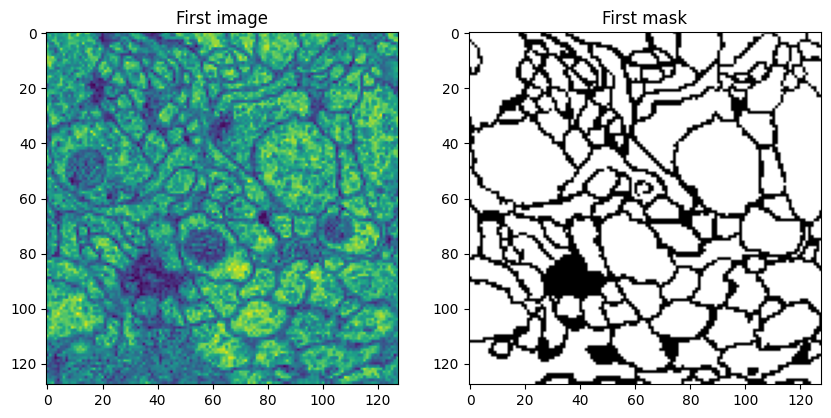

In [212]:
import os
import cv2
import numpy as np
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
from torch.utils.data import random_split
import tifffile as tiff

class ISBIDataset(Dataset):
    def __init__(self, image_path, mask_path, transform=None):
        self.image_stack = tiff.imread(image_path)  # Charge un fichier TIFF volumineux
        self.mask_stack = tiff.imread(mask_path)  # Charge les masques correspondants
        self.transform = transform

    def __len__(self):
        return len(self.image_stack)  # Le nombre d'images dans le fichier TIFF

    def __getitem__(self, index):
        image = self.image_stack[index]  # Extraire une image slice
        mask = self.mask_stack[index]    # Extraire le masque correspondant

        # Redimensionner les masques pour qu'ils correspondent à l'image
        if self.transform:
            augmented = self.transform(image=image, mask=mask)  # Appliquer les transformations
            image = augmented['image']  # Obtenir l'image transformée
            mask = augmented['mask']  # Obtenir le masque transformé

        # Ajouter une dimension (1 canal pour le masque)
        mask = mask / 255.0  # Ramène les valeurs dans [0, 1]
        mask = np.expand_dims(mask, axis=0)

        return image, mask



# Define transformations
transform = A.Compose([
    A.Resize(128, 128),  # Resize images and masks
    A.HorizontalFlip(p=0.5),  # Random horizontal flip
    A.VerticalFlip(p=0.5),  # Random vertical flip
    A.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0]),  # Normalize images
    ToTensorV2(),  # Convert to PyTorch tensors
])

# Définir les chemins
image_path = '/content/drive/MyDrive/ISBI-2012-challenge/train-volume.tif'
mask_path = '/content/drive/MyDrive/ISBI-2012-challenge/train-labels.tif'


# Charger le dataset
train_dataset = ISBIDataset(image_path, mask_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataset=ISBIDataset('/content/drive/MyDrive/ISBI-2012-challenge/test-volume.tif', '/content/drive/MyDrive/ISBI-2012-challenge/test-labels.tif', transform=transform)
test_loader=DataLoader(test_dataset, batch_size=4, shuffle=False)
# Taille de votre dataset
total_size = len(train_dataset)
train_size = int(0.8 * total_size)  # 80% pour l'entraînement
val_size = total_size - train_size  # 20% pour la validation

# Diviser le dataset
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Créer les DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# Afficher le nombre d'images
print(f"Nombre d'images dans le dataset : {len(train_dataset)}")


# Print the shape of the first batch
for batch in train_loader:
    images, masks = batch
    print(f"Batch image shape: {images.shape}")  # Shape: (batch_size, C, H, W)
    print(f"Batch mask shape: {masks.shape}")  # Shape: (batch_size, 1, H, W)
    break

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(images[0].permute(1, 2, 0).numpy())  # Afficher l'image
plt.title("First image")

plt.subplot(1, 2, 2)
plt.imshow(masks[0].squeeze().numpy(), cmap="gray")  # Afficher le masque
plt.title("First mask")
plt.show()



## 3. U-Net Model Architecture
We will now define the U-Net model. The following implementation has an encoder-decoder structure, which is suitable for segmentation tasks.


In [213]:
import torch
import torch.nn as nn

# Bloc de convolution avec Conv2D, BatchNorm et ReLU
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

# Bloc Down: Deux convolutions suivies d'un MaxPool
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.conv_block1 = ConvBlock(in_channels, out_channels)
        self.conv_block2 = ConvBlock(out_channels, out_channels)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        return x, self.max_pool(x)

# Bloc Up: Transposed convolution, concaténation et deux convolutions
class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv_block1 = ConvBlock(in_channels, out_channels)
        self.conv_block2 = ConvBlock(out_channels, out_channels)

    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)  # Concaténation le long du canal
        x = self.conv_block1(x)
        return self.conv_block2(x)

# Bloc de sortie avec une seule convolution 1x1
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels=1):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

# Modèle complet U-Net
class UNet(nn.Module):
    def __init__(self, in_channels=1, n_classes=1, n_filters=64, n_blocks=4):
        super(UNet, self).__init__()
        # Encoder
        self.encoder = nn.ModuleList()
        for i in range(n_blocks):
            in_ch = in_channels if i == 0 else n_filters * (2 ** (i - 1))
            out_ch = n_filters * (2 ** i)
            self.encoder.append(Down(in_ch, out_ch))

        # Bottleneck
        self.bottleneck = nn.Sequential(
            ConvBlock(n_filters * (2 ** (n_blocks - 1)), n_filters * (2 ** n_blocks)),
            ConvBlock(n_filters * (2 ** n_blocks), n_filters * (2 ** n_blocks))
        )

        # Decoder
        self.decoder = nn.ModuleList()
        for i in range(n_blocks):
            in_ch = n_filters * (2 ** (n_blocks - i))
            out_ch = n_filters * (2 ** (n_blocks - i - 1))
            self.decoder.append(Up(in_ch, out_ch))

        # Output layer
        self.outconv = OutConv(n_filters, n_classes)

    def forward(self, x):
        # Encoder path with skip connections
        skips = []
        for down in self.encoder:
            x, x_down = down(x)
            skips.append(x)
            x = x_down

        # Bottleneck
        x = self.bottleneck(x)

        # Decoder path
        for i, up in enumerate(self.decoder):
            x = up(x, skips[-(i + 1)])

        # Output
        return self.outconv(x)

# Test du modèle
model = UNet(in_channels=3, n_classes=1, n_filters=64, n_blocks=4)
x = torch.randn(1, 3, 128, 128)  # Batch de taille 1, 3 canaux, 128x128
output = model(x)
print(output.shape)  # Doit être [1, 1, 128, 128]


torch.Size([1, 1, 128, 128])


In [214]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torchmetrics.classification import BinaryAccuracy

# LightningModule for training
class UNetModule(pl.LightningModule):
    def __init__(self,learning_rate=1e-3):
        super(UNetModule, self).__init__()
        self.model = UNet(in_channels=1, n_classes=1, n_filters=64, n_blocks=4)
        self.criterion = nn.BCEWithLogitsLoss()
        self.accuracy = BinaryAccuracy()
        self.learning_rate = learning_rate

    def forward(self, x):
        """Effectue une passe avant."""
        return self.model(x)

    def training_step(self, batch, batch_idx):
        """Étape d'entraînement."""
        images, masks = batch
        masks = masks.float()  # Convertir les masques en float pour BCELoss
        outputs = self(images)
        loss = self.criterion(outputs, masks)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        """Étape de validation."""
        images, masks = batch

        # Prépare les masques pour correspondre aux prédictions
        masks = masks.float()  # Assurez-vous que c'est du float pour la fonction de perte

        # Passe avant
        predictions = self.forward(images)

        # Appliquer une sigmoid pour obtenir des probabilités (0-1)
        preds = torch.sigmoid(predictions) > 0.5  # Binarisation

        # Calcul de la métrique d'accuracy
        acc = self.accuracy(preds.int(), masks.int())  # Accuracy prend en compte des ints

        # Calcul de la perte
        loss = self.criterion(predictions, masks)

        # Enregistrement des résultats
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_accuracy", acc, prog_bar=True)
        return {"val_loss": loss, "val_accuracy": acc}



    def test_step(self, batch, batch_idx):
        images, masks = batch
        predictions = self.forward(images)
        masks = masks.float()  # Assurez-vous que les masques sont en float pour la BCEWithLogitsLoss
        loss = self.criterion(predictions, masks)

        # Appliquer la sigmoid et binariser les prédictions
        preds = torch.sigmoid(predictions) > 0.5
        acc = self.accuracy(preds.int(), masks.int())  # Accuracy attend des ints

        self.log("test_loss", loss, prog_bar=True, logger=True)
        self.log("test_accuracy", acc, prog_bar=True)
        return {"test_loss": loss, "test_accuracy": acc}


    def test_epoch_start(self):
        # Réinitialisation des variables pour accumuler l'accuracy
        self.acc = 0

    def on_test_epoch_end(self):
        # Calcul de la précision finale pour l'ensemble du test
        self.acc = self.accuracy.compute()  # Calcul de la précision moyenne sur l'ensemble du test
        self.log('Final Accuracy', self.acc)  # Log de la précision finale
        self.accuracy.reset()  # Réinitialisation des métriques pour la prochaine évaluation

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        return optimizer

    def train_dataloader(self):
        return train_loader  # Assurez-vous que train_loader est défini avant de l'utiliser

    def val_dataloader(self):
        return val_loader  # Assurez-vous que val_loader est défini avant de l'utiliser

    def test_dataloader(self):
        return test_loader  # Assurez-vous que val_loader est défini avant de l'utiliser


## 4. Training the Model
We can now train the U-Net model using PyTorch Lightning's `Trainer` class.

In [215]:
# Créer une instance du module Lightning avec votre modèle U-Net
unet_module = UNetModule()

# Créer le trainer et commencer l'entraînement
trainer = pl.Trainer(max_epochs=10, accelerator='gpu')  # Ou utilisez un GPU si disponible
trainer.fit(unet_module)  # Passez l'instance de UNetModule, pas directement UNet


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | UNet              | 31.0 M | train
1 | criterion | BCEWithLogitsLoss | 0      | train
2 | accuracy  | BinaryAccuracy    | 0      | train
--------------------------------------------------------
31.0 M    Trainable params
0         Non-trainable params
31.0 M    Total params
124.169   Total estimated model params size (MB)
96        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [216]:
trainer.test(unet_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      Final Accuracy       │    0.8228352665901184     │
│       test_accuracy       │    0.8473449945449829     │
│         test_loss         │    0.3407171368598938     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.3407171368598938,
  'test_accuracy': 0.8473449945449829,
  'Final Accuracy': 0.8228352665901184}]

## 5. Evaluation and Visualization
We will now evaluate the model and visualize the segmentation results.

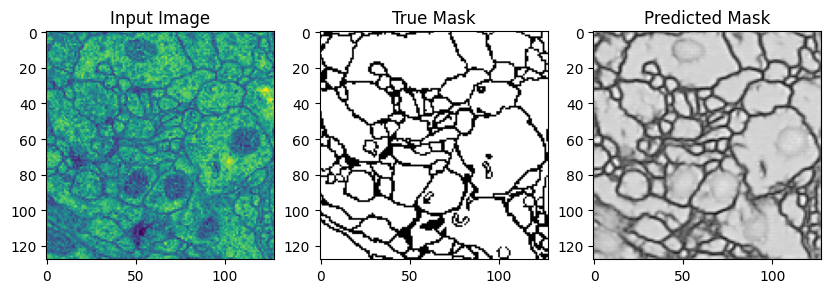

In [217]:
import matplotlib.pyplot as plt

def visualize_sample(model, dataloader):
    model.eval()
    with torch.no_grad():
        for image, mask in dataloader:
            pred_mask = unet_module(image)
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 3, 1)
            plt.imshow(image[0].permute(1, 2, 0).cpu().numpy())
            plt.title("Input Image")
            plt.subplot(1, 3, 2)
            plt.imshow(mask[0].squeeze().cpu().numpy(), cmap="gray")
            plt.title("True Mask")
            plt.subplot(1, 3, 3)
            plt.imshow(pred_mask[0].squeeze().cpu().numpy(), cmap="gray")
            plt.title("Predicted Mask")
            plt.show()
            break

# Visualize a sample from the validation set
visualize_sample(model, train_loader)


## Conclusion
In this lab, we implemented a U-Net model for image segmentation using PyTorch Lightning. We trained the model on the ISBI Cell Segmentation dataset and visualized the segmentation results.

You can further improve the model by using a deeper U-Net architecture, adding more data augmentation techniques, and fine-tuning the hyperparameters.